# LINEAR REGRESSION MODEL for predicting Customer Loyalty Score using TensorFlow

_Data is from https://www.kaggle.com/datasets/hanaksoy/customer-purchasing-behaviors/data_

__About Dataset__

customer_id: Unique ID of the customer.<br>
age: The age of the customer.<br>
annual_income: The customer's annual income (in USD).<br>
purchase_amount: The total amount of purchases made by the customer (in USD).<br>
purchase_frequency: Frequency of customer purchases (number of times per year).<br>
region: The region where the customer lives (North, South, East, West).<br>
loyalty_score: Customer's loyalty score (a value between 0-10).

__Problem Statement:__<br>
Based on existing data detailing the age, annual income, purchase amount, purchase frequency, and region of a new customer, predict the customer's loyalty score in order to if the customer is likely to organically build loyalty with the brand or if they may require extra services in order to build loyalty with the brand.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping

import joblib

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

## 1. Load and prepare data

Choose features: age, annual income, purchase amount, purchase frequency<br>
Choose target: loyalty score<br>

In [2]:
# Load data
data_path = "/kaggle/input/customer-purchasing-behaviors/Customer Purchasing Behaviors.csv"
raw_dataset = pd.read_csv(data_path)

# Duplicate data
dataset = raw_dataset.copy()

# Handle missing values
dataset = dataset.dropna()

dataset.shape

(238, 7)

In [3]:
dataset.head()

,user_id,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency
0,1,25,45000,200,4.5,North,12
1,2,34,55000,350,7.0,South,18
2,3,45,65000,500,8.0,West,22
3,4,22,30000,150,3.0,East,10
4,5,29,47000,220,4.8,North,13


In [4]:
dataset['loyalty_score'].describe()

count    238.000000
mean       6.794118
std        1.899047
min        3.000000
25%        5.500000
50%        7.000000
75%        8.275000
max        9.500000
Name: loyalty_score, dtype: float64

In [5]:
features = ['age', 'annual_income', 'purchase_amount', 'purchase_frequency']
target = ['loyalty_score']

X = dataset[features]
y = dataset[target]

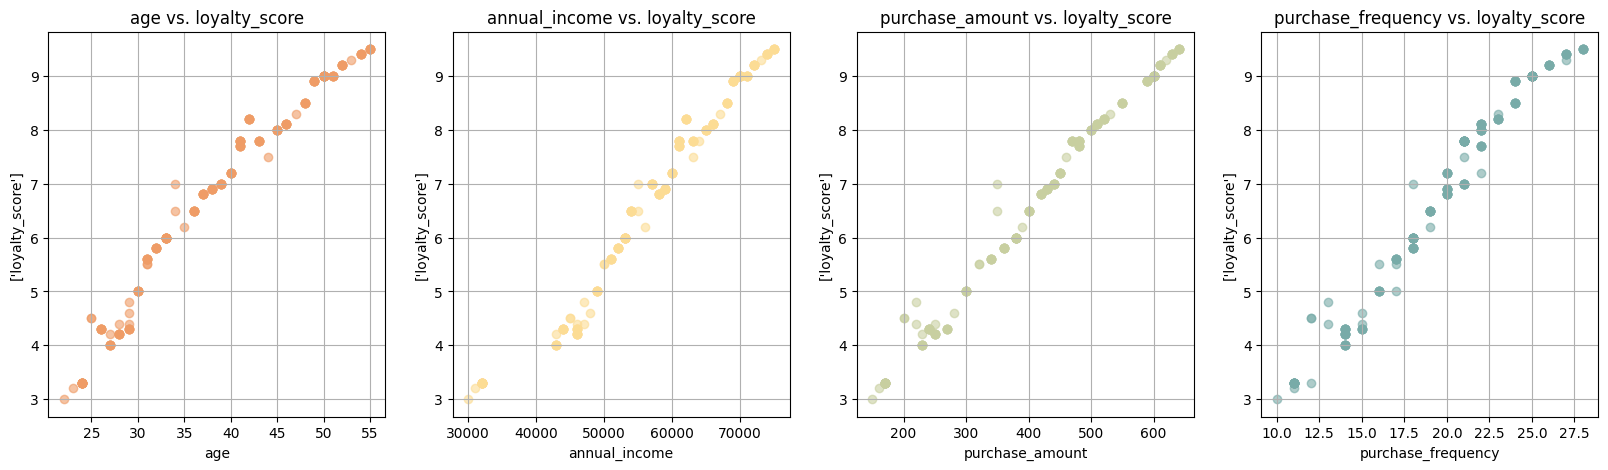

In [6]:
color = ['#EF9C66', '#FCDC94', '#C8CFA0', '#78ABA8']

plt.figure(figsize=(20, 5))  # Adjust figure size for horizontal layout (width, height)

for index, feature in enumerate(features):
    plt.subplot(1, 4, index + 1)  # (rows, columns, subplot_index) - subplot_index starts from 1
    plt.scatter(dataset[feature], dataset[target], color=color[index], alpha=0.6)
    plt.title(f'{feature} vs. {target[0]}') # Shortened title for cleaner grid
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.grid(True)

## 2. Data Preprocessing

In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

pipeline.fit(X) # fit the preprocessor on ALL data before saving for consistent scaling in API
joblib.dump(pipeline, 'predicting_customer_loyalty_preprocessor.joblib') # save the fitted preprocessor

['predicting_customer_loyalty_preprocessor.joblib']

### Split data for training and testing

Choose 90-10 train-test data split.

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # Split FIRST

X_train_val_processed = pipeline.transform(X_train_val) # Transform training+validation data using fitted pipeline
X_test_processed = pipeline.transform(X_test)         # Transform test data using the SAME fitted pipeline

X_train, X_val, y_train, y_val = train_test_split(X_train_val_processed, y_train_val, test_size=0.1, random_state=42) # Split training for validation during training

## 3. Create and train the model

In [9]:
model = tf.keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation='linear', kernel_initializer='zeros', bias_initializer='zeros')
])

model.compile(
    optimizer='adam', 
    loss='mse'
)

In [10]:
epochs = 4000
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_split=0.2, 
    verbose=0
)

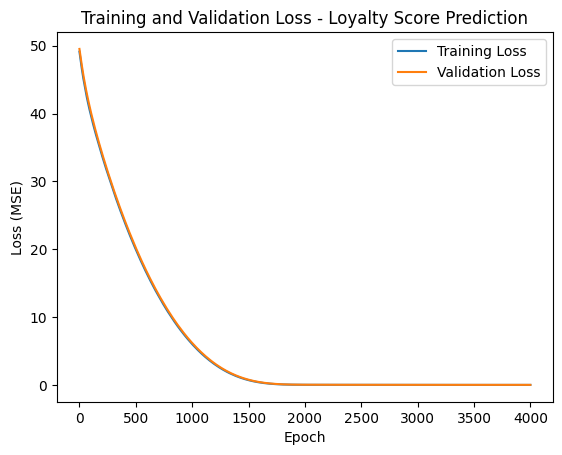

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - Loyalty Score Prediction')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

## 4. Evaluate the model

In [14]:
# Compute for the MAE
y_pred = model.predict(X_test_processed)
mae = np.mean(np.abs(y_pred.flatten() - y_test.values.flatten()))
print(f"Mean Absolute Error on Test Set: {mae}")

# Compute for the MSE
loss = model.evaluate(X_test_processed, y_test, verbose=0)
print(f"Mean Squared Error on Test Set: {loss}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred) 
print(f'TensorFlow Model R-squared: {r2 * 100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Mean Absolute Error on Test Set: 0.1328026831150055
Mean Squared Error on Test Set: 0.037510763853788376
TensorFlow Model R-squared: 98.96%


## Final R-Squared Score: 98.96%

## 5. Save the Model

In [15]:
model.save('loyalty_model.h5')

print("\nModel and preprocessor saved for API deployment!")
print("Preprocessor saved as: preprocessor.joblib")
print("Model saved as: loyalty_model (directory)")


Model and preprocessor saved for API deployment!
Preprocessor saved as: preprocessor.joblib
Model saved as: loyalty_model (directory)
